# PRS map - summary plots

Yosuke Tanigawa


## library, functions, and constants

In [42]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


In [43]:
source('paths.sh')
devtools::load_all(cud4_d)
source(snpnet_helper)


ℹ Loading cud4



In [44]:
traits_w_metrics_f %>%
fread() %>%
rename_with(
    function(x){str_replace(x, '#', '')}, starts_with("#")
) %>%
mutate(
    trait_label=sprintf('%s (%s)', trait_name, trait),
) -> traits_w_metrics_df


In [45]:
traits_w_metrics_df%>%
count(WBtest_is_significant, family) %>%
spread(family, n) %>%
arrange(-WBtest_is_significant)


WBtest_is_significant,binomial,gaussian
<lgl>,<int>,<int>
TRUE,244,569
FALSE,450,302


In [46]:
eval_full_f %>%
fread() %>%
rename_with(
    function(x){str_replace(x, '#', '')}, starts_with("#")
) -> eval_full_df


In [47]:
# GWAS h2 table (heritability)
GWAS_h2_f %>% 
fread() %>%
rename_with(
    function(x){str_replace(x, '#', '')}, starts_with("#")
) -> GWAS_h2_df


## Export LDSC-based heritability estimates

In [ ]:
traits_w_metrics_df %>%
filter(WBtest_is_significant) %>%
select(trait, trait_name, trait_category, family) %>%
left_join(
    GWAS_h2_df, by=c('trait'='p')
) %>%
rename('#trait' = 'trait') %>%
fwrite('LDSCh2.tsv', sep='\t', na = "NA", quote=F)


## Histogram - incremental predictive performance

In [48]:
p_histo_binomial <- traits_w_metrics_df %>%  
filter(
    WBtest_is_significant,
    family == 'binomial'
) %>%
ggplot(aes(x = pred_delta)) +
geom_vline(xintercept = 0, color='red') +
geom_histogram(bins=30) +
theme_bw(base_size = 16) +
labs(
    title = 'Binary traits (Binomial model)',
    x = latex2exp::TeX('Incremental AUC'),
    y = 'Number of traits'
)

p_histo_gaussian <- traits_w_metrics_df %>%  
filter(
    WBtest_is_significant,
    family == 'gaussian'
) %>%
ggplot(aes(x = pred_delta)) +
geom_vline(xintercept = 0, color='red') +
geom_histogram(bins=30) +
theme_bw(base_size = 16) +
labs(
    title = 'Quantitative traits (Gaussian model)',
    x = latex2exp::TeX('Incremental \\textit{R}$^2$'),
    y = 'Number of traits'
)


In [49]:
for(ext in c('png', 'pdf')){ggsave(
    sprintf('incremental-R2AUC.%s', ext),
    gridExtra::arrangeGrob(
        p_histo_binomial,
        p_histo_gaussian,
        ncol=2
    ),
    width=16, height=8
)}


## Predictive performance vs. model size plot

- x-axis: log10(number of variants in the PRS model),
- y-axis: the delta in predictive performance (do color coding by gaussian, binomial, etc family)


### relationship between the two variables

In [50]:
cor_test_wrapper <- function(df, cor_test_method){cor.test(
    df %>% pull(pred_delta),
    df %>% pull(n_variables),
    method = cor_test_method
)}


In [51]:
traits_w_metrics_df %>%  
filter(
    WBtest_is_significant,
    family == 'binomial'
) %>%
cor_test_wrapper('spearman') -> rho_binomial

traits_w_metrics_df %>%  
filter(
    WBtest_is_significant,
    family == 'gaussian'
) %>%
cor_test_wrapper('spearman') -> rho_gaussian


Warning message in cor.test.default(df %>% pull(pred_delta), df %>% pull(n_variables), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(df %>% pull(pred_delta), df %>% pull(n_variables), :
“Cannot compute exact p-value with ties”


In [52]:
rho_binomial %>% print
rho_gaussian %>% print
rho_gaussian$p.value %>% print


	Spearman's rank correlation rho

data:  df %>% pull(pred_delta) and df %>% pull(n_variables)
S = 2348637, p-value = 0.6418
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.02992588 


	Spearman's rank correlation rho

data:  df %>% pull(pred_delta) and df %>% pull(n_variables)
S = 11962011, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.6103991 

[1] 2.210457e-59


### list of traits to annotate in the plot

In [168]:
p_delta_vs_size_labels <- data.frame(
    plot_label = c(
        # Binary traits
        'Iritis',
        'Porphyrin and\nbilirubin metabolism\ndisorders (TTE)',
        'Hair color (red)',
        'Hair color (blonde)',
        'Hair color (dark brown)',
        'Celiac disease',
        'Genetic\nhematological\ndisorder',
        'Type 1 diabetes',
        'Ankylosing\nspondylitis',
        'Other coagulation\ndefects (TTE)',
        'Intestinal malabsorption (TTE)',
#         'Never Smoker',
        # Quantitative traits
        'Lipoprotein A',
        'Total bilirubin',
        'Direct billirubin',
        'Mean platelet volume',
        'Apolipoprotein B',
        'EBNA-1 antigen for\nEpstein-Barr Virus',
        'Standing\nheight',
        'Heel bone mineral density'
    ),
    trait = c(
        # Binary traits
        'HC26',
        'HC702',
        'BIN_FC2001747',
        'BIN_FC1001747',
        'BIN_FC4001747',
        'HC303',
        'HC413',
        'HC337',
        'HC422',
        'HC624',
        'HC1132',
#         'BIN_FC10020116',
        # Quantitative traits
        'INI30790',
        'INI30840',
        'INI30660',
        'INI30100',
        'INI30640',
        'INI23004',
        'INI50',
        'INI3148'
    ),
    stringsAsFactors=F
)


### plot size vs delta (incremental predictive performance)

In [169]:
p_delta_vs_size_binomial <- traits_w_metrics_df %>%  
filter(
    WBtest_is_significant,
    family == 'binomial'
) %>%
left_join(p_delta_vs_size_labels, by='trait') %>%
replace_na(list('plot_label'='')) %>%
ggplot(aes(x  = n_variables, y = pred_delta, color=trait_category_plot, label=trait_label)) +
geom_point(alpha=.5) + scale_x_continuous(trans='log10') +
theme_bw(base_size = 16) + labs(
    title = 'Binary traits (Binomial model)',
    x = 'Number of genetic variants',
    y = 'Incremental AUC',
    color = 'Trait category'
) + 
theme(legend.position = 'bottom') +
guides(
  color = guide_legend(
    title = 'Trait category',
    override.aes = aes(label = "", alpha=1),
    ncol=2
  )
)

p_delta_vs_size_gaussian <- traits_w_metrics_df %>%  
filter(
    WBtest_is_significant,
    family == 'gaussian'
) %>%
left_join(p_delta_vs_size_labels, by='trait') %>%
replace_na(list('plot_label'='')) %>%
ggplot(aes(x  = n_variables, y = pred_delta, color=trait_category_plot, label=trait_label)) +
geom_point(alpha=.5) + scale_x_continuous(trans='log10') +
theme_bw(base_size = 16) + labs(
    title = 'Quantitative traits (Gaussian model)',
    x = 'Number of genetic variants',
    y = latex2exp::TeX('Incremental \\textit{R}$^2$'),
    color = 'Trait category'
) + 
theme(legend.position = 'bottom') +
guides(
  color = guide_legend(
    title = 'Trait category',
    override.aes = aes(label = "", alpha=1),
    ncol=2
  )
)

In [170]:
for(ext in c('png', 'pdf')){ggsave(
    sprintf('size_vs_delta.%s', ext),
    gridExtra::arrangeGrob(
        # binomial
        p_delta_vs_size_binomial  +
        annotate(
            geom="text", x = 1, y = .38, color="black", hjust = 0, parse = TRUE, size = 7,
            label=sprintf(
                "\"Spearman's\" ~ rho == %0.2f",
                round(rho_binomial$estimate, 2)
            ),
        ) + annotate(
            geom="text", x = 1, y = .35, color="black", hjust = 0, parse = TRUE, size = 7,
            label = sprintf(
                "\"(p-value: \" * %.1e * \")\"",
                rho_binomial$p.value
            )
        ) +
        ggrepel::geom_text_repel(force=20, mapping = aes(label = plot_label)),
        # gaussian
        p_delta_vs_size_gaussian  +
        annotate(
            geom="text", x = 1, y = .35, color="black", hjust = 0, parse = TRUE, size = 7,
            label=sprintf(
                "\"Spearman's\" ~ rho == %0.2f",
                round(rho_gaussian$estimate, 2)
            ),
        ) + annotate(
            geom="text", x = 1, y = .32, color="black", hjust = 0, parse = TRUE, size = 7,
            label = sprintf(
                "\"(p-value: \" * %.1e * \")\"",
                rho_gaussian$p.value
            )
        ) +
        ggrepel::geom_text_repel(force=20, mapping = aes(label = plot_label)),
        # format
        ncol=2
    ),
    width=16, height=9
)}

### export them to plotly plots
Those files are now hosted on AFS (/afs/ir.stanford.edu/users/y/t/ytanigaw/WWW/PRSmap)
- http://web.stanford.edu/~ytanigaw/PRSmap/size_vs_delta_binomial.html
- http://web.stanford.edu/~ytanigaw/PRSmap/size_vs_delta__gaussian.html


In [171]:
htmlwidgets::saveWidget(
    p_delta_vs_size_binomial %>% plotly::ggplotly(),
    'ggplotly/size_vs_delta_binomial.html'
)

htmlwidgets::saveWidget(
    (p_delta_vs_size_gaussian +
     # ggplotly does not support LaTex equation
    labs(y = 'Incremental R^2') )%>% plotly::ggplotly(),
    'ggplotly/size_vs_delta_gaussian.html'
)


In [172]:
for(ext in c('png', 'pdf')){
    ggsave(
        sprintf('size_vs_delta_binomial.%s', ext),
        p_delta_vs_size_binomial  +
        annotate(
            geom="text", x = 1, y = .38, color="black", hjust = 0, parse = TRUE, size = 7,
            label=sprintf(
                "\"Spearman's\" ~ rho == %0.2f",
                round(rho_binomial$estimate, 2)
            ),
        ) + annotate(
            geom="text", x = 1, y = .35, color="black", hjust = 0, parse = TRUE, size = 7,
            label = sprintf(
                "\"(p-value: \" * %.1e * \")\"",
                rho_binomial$p.value
            )
        ) +
        ggrepel::geom_text_repel(force=20, mapping = aes(label = plot_label)),
        width=8, height=9
    )
    ggsave(
        sprintf('size_vs_delta_gaussian.%s', ext),

        # gaussian
        p_delta_vs_size_gaussian  +
        annotate(
            geom="text", x = 1, y = .35, color="black", hjust = 0, parse = TRUE, size = 7,
            label=sprintf(
                "\"Spearman's\" ~ rho == %0.2f",
                round(rho_gaussian$estimate, 2)
            ),
        ) + annotate(
            geom="text", x = 1, y = .32, color="black", hjust = 0, parse = TRUE, size = 7,
            label = sprintf(
                "\"(p-value: \" * %.1e * \")\"",
                rho_gaussian$p.value
            )
        ) +
        ggrepel::geom_text_repel(force=20, mapping = aes(label = plot_label)),
        width=8, height=9
    )
}


## R2 vs h2 plot

In [58]:
p_h2_vs_geno_labels <- data.frame(
    plot_label = c(
        # Binary traits
        'Started insulin within one year diagnosis of diabetes',
        'JCV seropositivity for Human Polyomavirus JCV',
        'MCV seropositivity for Merkel Cell Polyomavirus',
        'Ease of skin tanning\n(Never tan, only burn)',
        'Hair color (red)',
        'Hair color (blonde)',
        'Hair color\n(dark brown)',
        'Hair color (brown)',
        'Hair color (black)',
        'Hair color (light brown)',
        'Hypertension',
        'High Blood Pressure diagnosed by doctor',
        # Quantitative traits
        'Platelet distribution width',
        'Mean corpuscular volume',
        'Platelet count',
        '6mm weak meridian (left)',
        'Lipoprotein A',
        'Total bilirubin',
        'Direct billirubin',
        'Mean platelet volume',
        'EBNA-1 antigen for Epstein-Barr Virus',
        'Standing height'
    ),
    trait = c(
        # Binary traits
        'BIN_FC10002986',
        'BIN23066',
        'BIN23067',
        'BIN_FC40001727',
        'BIN_FC2001747',
        'BIN_FC1001747',
        'BIN_FC4001747',
        'BIN_FC7001747',
        'BIN_FC5001747',
        'BIN_FC3001747',
        'HC215',
        'BIN_FC4006150',
        # Quantitative traits
        'INI30110',
        'INI30040',
        'INI30080',
        'INI5097',
        'INI30790',
        'INI30840',
        'INI30660',
        'INI30100',
        'INI23004',
        'INI50'
    ),
    stringsAsFactors=F
)

In [59]:
p_h2_vs_geno_sub_labels <- data.frame(
    plot_sub_label = c(
        # Binary traits
        'Asthma diagnosed by doctor',
        'Hayfever rhinitis or eczema diagnosed by doctor',
        'Hypothyroidism/myxoedema',
        'Hayfever allergic rhinitis or eczema',
        'Never Smoker',
        'TTE disorders of\nporphyrin and\nbilirubin metabolism',
        'Coeliac disease',
        'Non-melanoma skin cancer',
        'Skin cancer',
        'Diabetes',
        'Psoriasis',
#         'Snoring',
        'Worrier / anxious feelings',
#         'Past tobacco smoking\n(Smoked at least once)',
        
        # Quantitative traits
        'Apolipoprotein B',
        'Mean reticulocyte volume',
        'Heel BMD', #bone mineral density
#         'Apolipoprotein A',
        'IGF-1',
        'Red blood cell count',
#         'High light scatter\nreticulocyte count'
        'LDL cholesterol',
        'Cholesterol',
        'Neutrophill %',
        'Peak expiratory flow\npredicted ratio',
        'Vitamin D',
        'Basophill %'
    ),
    trait = c(
        # Binary traits
        'BIN_FC4006152',
        'BIN_FC5006152',
        'HC219',
        'BIN_FC10006152',
        'BIN_FC10020116',
        'HC702',
        'HC303',
        'cancer1060',
        'cancer1003',    
        'HC221',
        'HC38',
#         'BIN1210',
        'BIN1980',
#         'BIN_FC40001249',
        
        # Quantitative traits
        'INI30640',
        'INI30260',
        'INI3148',
#         'INI30630',
        'INI30770',
        'INI30010',
#         'INI30300'
        'INI30780',
        'INI30690',
        'INI30200',
        'INI1003064',
        'INI30890',
        'INI30220'
    ),
    stringsAsFactors=F
)

In [60]:
h2_vs_geno_df <- eval_full_df %>%
filter(
    WBtest_is_significant,
    model=='PRS',
    split == 'test',
    metric %in% c('r2', 'TjurR2')
#     metric == c('r2', 'NagelkerkeR2')
) %>%
mutate(
    trait_label=sprintf('%s (%s)', trait_name, trait),
) %>%
left_join(
    GWAS_h2_df %>%
    rename('trait'='p') %>%
    select(trait, h2_obs, h2_obs_se) %>%
    unique %>%
    filter(! is.na(h2_obs)),
    by="trait"
) %>%
left_join(p_h2_vs_geno_labels, by='trait') %>%
left_join(p_h2_vs_geno_sub_labels, by='trait') %>%
replace_na(list('plot_label'='', 'plot_sub_label'=''))


In [61]:
c('binomial', 'gaussian') %>%
lapply(function(fam){
    glm(
        `eval` ~ 0 + h2_obs,
        data = h2_vs_geno_df %>% filter(family == fam)
    ) %>%
    fit_to_df() %>%
    mutate(family = fam)
}) %>% bind_rows -> h2_vs_geno_regression_df



In [62]:
h2_vs_geno_regression_df


variable,estimate,SE,z_or_t_value,P,family
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
h2_obs,0.2019018,0.029154490,6.925237,3.865663e-11,binomial
h2_obs,0.1521934,0.008071877,18.854775,6.041847e-62,gaussian


In [63]:
p_h2_vs_geno_binomial <- h2_vs_geno_df %>%
filter(family == 'binomial') %>%
ggplot(aes(x  = h2_obs, y = `eval`, color=trait_category_plot, label=trait_label)) +
geom_errorbarh(aes(xmin = h2_obs - h2_obs_se, xmax = h2_obs + h2_obs_se), alpha=.2) +
geom_abline(
    intercept=0,
    slope=h2_vs_geno_regression_df %>% filter(family == 'binomial') %>% pull(estimate),
    color='gray',
    linetype = "dashed"
) +
geom_abline(intercept=0, slope=1, color='gray') +
geom_point(alpha=.5) +
theme_bw(base_size = 16) + labs(
    title = 'Binary traits (Binomial model)',
    x = 'Estimated SNP-based heritability [SE]',
    y = latex2exp::TeX('Predictive performance (Tjur\'s pseudo \\textit{R}$^2$)'),
    color = 'Trait category'
) + 
theme(legend.position = 'bottom') +
guides(
  color = guide_legend(
    title = 'Trait category',
    override.aes = aes(label = "", alpha=1),
    ncol=2
  )
)

p_h2_vs_geno_gaussian <- h2_vs_geno_df %>%
filter(family == 'gaussian') %>%
ggplot(aes(x  = h2_obs, y = `eval`, color=trait_category_plot, label=trait_label)) +
geom_errorbarh(aes(xmin = h2_obs - h2_obs_se, xmax = h2_obs + h2_obs_se), alpha=.2) +
geom_abline(
    intercept=0,
    slope=h2_vs_geno_regression_df %>% filter(family == 'gaussian') %>% pull(estimate),
    color='gray',
    linetype = "dashed"
) +
geom_abline(intercept=0, slope=1, color='gray') +
geom_point(alpha=.5) +
theme_bw(base_size = 16) + labs(
    title = 'Quantitative traits (Gaussian model)',
    x = 'Estimated SNP-based heritability [SE]',
    y = latex2exp::TeX('Predictive performance (\\textit{R}$^2$)'),
    color = 'Trait category'
) + 
theme(legend.position = 'bottom') +
guides(
  color = guide_legend(
    title = 'Trait category',
    override.aes = aes(label = "", alpha=1),
    ncol=2
  )
)


In [64]:
for(ext in c('png', 'pdf')){ggsave(
    sprintf('h2_vs_geno.%s', ext),
    gridExtra::arrangeGrob(
        # binomial
        p_h2_vs_geno_binomial +
        geom_rect(mapping=aes(xmin=0, xmax=.14, ymin=0, ymax=.038), color="black", alpha=0, size=.05) +
        annotation_custom(
            ggplotGrob(
                p_h2_vs_geno_binomial +
                theme(
                    legend.position = 'none',
                    axis.title.x=element_blank(),
                    axis.title.y=element_blank(),
                    title=element_blank()
                ) +
                xlim(0, 0.14) + ylim(0, 0.038) +
                ggrepel::geom_text_repel(max.overlaps=30, force=20, mapping = aes(label = plot_sub_label))
            ), 
            xmin = .3, xmax = 1.15, ymin = .11, ymax = 0.51
        ) +
        ggrepel::geom_text_repel(max.overlaps=30, force=20, mapping = aes(label = plot_label)),
        # gaussian
        p_h2_vs_geno_gaussian  +
        geom_rect(mapping=aes(xmin=0, xmax=.3, ymin=0, ymax=.15), color="black", alpha=0, size=.05) +
        annotation_custom(
            ggplotGrob(
                p_h2_vs_geno_gaussian +
                theme(
                    legend.position = 'none',
                    axis.title.x=element_blank(),
                    axis.title.y=element_blank(),
                    title=element_blank()
                ) +
                xlim(0, 0.3) + ylim(0, 0.15) +
                ggrepel::geom_text_repel(max.overlaps=30, force=20, mapping = aes(label = plot_sub_label))
            ), 
            xmin = .5, xmax = 1.28, ymin = .16, ymax = 0.56
        ) +
        ggrepel::geom_text_repel(max.overlaps=30, force=20, mapping = aes(label = plot_label)),
        # format
        ncol=2
    ),
    width=16, height=9
)}

Warning message:
“Removed 14 rows containing missing values (geom_errorbarh).”
Warning message:
“Removed 14 rows containing missing values (geom_point).”
Warning message:
“Removed 14 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 172 rows containing missing values (geom_errorbarh).”
Warning message:
“Removed 113 rows containing missing values (geom_point).”
Warning message:
“Removed 113 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 14 rows containing missing values (geom_errorbarh).”
Warning message:
“Removed 14 rows containing missing values (geom_point).”
Warning message:
“Removed 14 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 172 rows containing missing values (geom_errorbarh).”
Warning message:
“Removed 113 rows containing missing values (geom_point).”
Warning message:
“Removed 113 rows containing missing values (geom_text_repel).”


In [65]:
htmlwidgets::saveWidget(
    (p_h2_vs_geno_binomial +
     # ggplotly does not support LaTex equation
    labs(y = 'Predictive performance (Tjur\'s pseudo R^2)') ) %>% plotly::ggplotly(),
    'ggplotly/h2_vs_geno_binomial.html'
)

htmlwidgets::saveWidget(
    (p_h2_vs_geno_gaussian +
     # ggplotly does not support LaTex equation
    labs(y = 'Predictive performance (R^2)') )%>% plotly::ggplotly(),
    'ggplotly/h2_vs_geno_gaussian.html'
)

In [173]:
for(ext in c('png', 'pdf')){
    ggsave(
        sprintf('h2_vs_geno_binomial.%s', ext),
        
        # binomial
        p_h2_vs_geno_binomial +
        geom_rect(mapping=aes(xmin=0, xmax=.14, ymin=0, ymax=.038), color="black", alpha=0, size=.05) +
        annotation_custom(
            ggplotGrob(
                p_h2_vs_geno_binomial +
                theme(
                    legend.position = 'none',
                    axis.title.x=element_blank(),
                    axis.title.y=element_blank(),
                    title=element_blank()
                ) +
                xlim(0, 0.14) + ylim(0, 0.038) +
                ggrepel::geom_text_repel(max.overlaps=30, force=20, mapping = aes(label = plot_sub_label))
            ), 
            xmin = .3, xmax = 1.15, ymin = .11, ymax = 0.51
        ) +
        ggrepel::geom_text_repel(max.overlaps=30, force=20, mapping = aes(label = plot_label)),
        width=8, height=9
    )
    ggsave(
        sprintf('h2_vs_geno_gaussian.%s', ext),

        # gaussian
        p_h2_vs_geno_gaussian  +
        geom_rect(mapping=aes(xmin=0, xmax=.3, ymin=0, ymax=.15), color="black", alpha=0, size=.05) +
        annotation_custom(
            ggplotGrob(
                p_h2_vs_geno_gaussian +
                theme(
                    legend.position = 'none',
                    axis.title.x=element_blank(),
                    axis.title.y=element_blank(),
                    title=element_blank()
                ) +
                xlim(0, 0.3) + ylim(0, 0.15) +
                ggrepel::geom_text_repel(max.overlaps=30, force=20, mapping = aes(label = plot_sub_label))
            ), 
            xmin = .5, xmax = 1.28, ymin = .16, ymax = 0.56
        ) +
        ggrepel::geom_text_repel(max.overlaps=30, force=20, mapping = aes(label = plot_label)),
        
        width=8, height=9
    )
}


Warning message:
“Removed 14 rows containing missing values (geom_errorbarh).”
Warning message:
“Removed 14 rows containing missing values (geom_point).”
Warning message:
“Removed 14 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 172 rows containing missing values (geom_errorbarh).”
Warning message:
“Removed 113 rows containing missing values (geom_point).”
Warning message:
“Removed 113 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 14 rows containing missing values (geom_errorbarh).”
Warning message:
“Removed 14 rows containing missing values (geom_point).”
Warning message:
“Removed 14 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 172 rows containing missing values (geom_errorbarh).”
Warning message:
“Removed 113 rows containing missing values (geom_point).”
Warning message:
“Removed 113 rows containing missing values (geom_text_repel).”


## Transferability assessment

In [66]:
transferability_eval_func <- function(ancestry_group_metric, WB_test_set_metric){
    ancestry_group_metric - WB_test_set_metric
}


In [67]:
get_split_order_df <- function(){
    data.frame(
        split = c('non_british_white', 's_asian', 'e_asian', 'african'),
        split_plot = c('Non-British white', 'South Asian', 'East Asian', 'African'),
        split_order=1:4, stringsAsFactors=F
    )
}


In [68]:
get_split_color_dict <- function(){
    setNames(
        c(cud4_colors()['gray'], cud4_colors()['purple'], cud4_colors()['sky_blue'], cud4_colors()['orange'] ),
        c('Non-British white', 'South Asian', 'East Asian', 'African')
    )
}


In [69]:
traits_w_metrics_df %>% 
select(all_of(c(
    'trait', 'trait_name', 'trait_category',
    'trait_category_plot', 'trait_label',
    'family', 'WBtest_is_significant'
))) %>%
inner_join(    
    eval_full_df %>%
    drop_na(`eval`) %>%
    filter(metric %in% c('r2', 'auc')) %>%
    select(trait, model, split, `eval`) %>%
    spread(model, `eval`) %>%
    mutate(pred_delta = full - covar) %>%
    select(trait, split, pred_delta) %>%
    filter(
        split %in% c('test', 'non_british_white', 'african', 's_asian', 'e_asian')
    ) %>% 
    spread(split, pred_delta) %>%
    mutate(across(
        c('non_british_white', 'african', 's_asian', 'e_asian'),
        function(x){ transferability_eval_func(x, test) }
    )) %>%
    gather(split, pred_delta_vs_WBtest, -trait, -test) %>%
    drop_na(pred_delta_vs_WBtest) %>%
    rename(
        'pred_delta_WBtest'='test'
    ),
    by = "trait"
) %>%
left_join(
    get_split_order_df(),
    by = "split"
) -> transferability_df


In [70]:
transferability_df %>%
filter(WBtest_is_significant) %>%
count(split, family) %>%
spread(family, n)


split,binomial,gaussian
<chr>,<int>,<int>
african,241,569
e_asian,218,569
non_british_white,244,569
s_asian,242,569


This is consistent with what we have

In [71]:
eval_full_df %>%
drop_na(`eval`) %>%
filter(
    WBtest_is_significant,
    model %in% c('full'),
    split %in% c('non_british_white', 'african', 's_asian', 'e_asian'),
    metric %in% c('r2', 'auc')
) %>%
count(split, family) %>%
spread(family, n)


split,binomial,gaussian
<chr>,<int>,<int>
african,241,569
e_asian,218,569
non_british_white,244,569
s_asian,242,569


### median of the diff(incremental predictive performance in other ancestry group vs WB)

In [80]:
transferability_df %>%
group_by(family, split) %>% 
summarise(median = median(pred_delta_vs_WBtest), `.groups` = 'drop') %>% 
spread(family, median) %>%
left_join(
    get_split_order_df(),
    by = "split"
) %>%
arrange(split_order) -> transferability_median_df


In [81]:
transferability_median_df


split,binomial,gaussian,split_plot,split_order
<chr>,<dbl>,<dbl>,<chr>,<int>
non_british_white,-0.0005767017,-0.0002677496,Non-British white,1
s_asian,-0.0011065331,-0.0038936344,South Asian,2
e_asian,-0.0016157189,-0.0018617157,East Asian,3
african,-0.0019864951,-0.0060910854,African,4


### get the slope of regression

In [73]:
c('binomial', 'gaussian') %>%
lapply(function(fam){
    c('non_british_white', 'african', 's_asian', 'e_asian') %>%
    lapply(function(pop){
        glm(
            (pred_delta_WBtest + pred_delta_vs_WBtest) ~ 0 + pred_delta_WBtest,
            data = transferability_df %>%
            filter(family == fam, WBtest_is_significant) %>%
            filter(split == pop)
        ) %>%
        fit_to_df() %>%
        mutate(split = pop, family=fam)        
    }) %>%
    bind_rows
}) %>%
bind_rows %>%
select(family, split, variable, estimate, SE, z_or_t_value, P) %>%
left_join(
    get_split_order_df(),
    by = "split"
) %>%
arrange(family, -estimate) -> regression_slopes_df


In [74]:
regression_slopes_df

family,split,variable,estimate,SE,z_or_t_value,P,split_plot,split_order
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
binomial,non_british_white,pred_delta_WBtest,0.59823332,0.013207264,45.2957805,1.801242e-120,Non-British white,1
binomial,s_asian,pred_delta_WBtest,0.09520928,0.019663027,4.8420461,2.298400e-06,South Asian,2
binomial,e_asian,pred_delta_WBtest,0.01120164,0.024822109,0.4512768,6.522408e-01,East Asian,3
binomial,african,pred_delta_WBtest,-0.08594696,0.018821708,-4.5663742,7.933224e-06,African,4
gaussian,non_british_white,pred_delta_WBtest,0.91900382,0.006964856,131.9487174,0.000000e+00,Non-British white,1
gaussian,s_asian,pred_delta_WBtest,0.55964924,0.009856612,56.7790701,2.514568e-236,South Asian,2
gaussian,e_asian,pred_delta_WBtest,0.47423595,0.015762527,30.0862895,1.201520e-119,East Asian,3
gaussian,african,pred_delta_WBtest,0.13194371,0.011661471,11.3144990,6.601850e-27,African,4


### violin plots

In [150]:
p_trans_violin_binomial <- transferability_df %>%
filter(family == 'binomial', WBtest_is_significant) %>%
ggplot(aes(
    x=reorder(split_plot, split_order),
    y=pred_delta_vs_WBtest,
    color=reorder(split_plot, split_order)
)) + 
geom_hline(yintercept = 0, color='gray') +
geom_violin() +
geom_jitter(height = 0, width = 0.3) +
theme_bw(base_size = 16) + 
scale_color_manual(values=get_split_color_dict()) +
labs(
    title = 'Binary traits (Binomial model)',
    y = 'The difference in incremental AUC compared against white British',
    x = 'Ancestry group in UK Biobank'
) +
theme(legend.position = 'none') +
stat_summary(
    fun = "median",
    geom = "crossbar", 
    width = 0.8,
    color = "black"
) + 
annotate(
    geom="text", x = 1, y = .08, color="black", size = 6,
    label = transferability_median_df %>%
    filter(split == 'non_british_white') %>% pull(binomial) %>% round(5)
) + 
annotate(
    geom="text", x = 2, y = .04, color="black", size = 6,
    label = transferability_median_df %>%
    filter(split == 's_asian') %>% pull(binomial) %>% round(5)
) + 
annotate(
    geom="text", x = 3, y = .04, color="black", size = 6,
    label = transferability_median_df %>%
    filter(split == 'e_asian') %>% pull(binomial) %>% round(5)
) + 
annotate(
    geom="text", x = 4, y = .04, color="black", size = 6,
    label = transferability_median_df %>%
    filter(split == 'african') %>% pull(binomial) %>% round(5)
)


p_trans_violin_gaussian <- transferability_df %>%
filter(family == 'gaussian', WBtest_is_significant) %>%
ggplot(aes(
    x=reorder(split_plot, split_order),
    y=pred_delta_vs_WBtest,
    color=reorder(split_plot, split_order)
)) + 
geom_hline(yintercept = 0, color='gray') +
geom_violin() +
geom_jitter(height = 0, width = 0.3) +
theme_bw(base_size = 16) + 
scale_color_manual(values=get_split_color_dict()) +
labs(
    title = 'Quantitative traits (Gaussian model)',
    y = latex2exp::TeX('The difference in incremental \\textit{R}$^2$ compared against white British') ,
    x = 'Ancestry group in UK Biobank'
) +
theme(legend.position = 'none') +
stat_summary(
    fun = "median",
    geom = "crossbar", 
    width = 0.8,
    color = "black"
) + 
annotate(
    geom="text", x = 1, y = .08, color="black", size = 6,
    label = transferability_median_df %>%
    filter(split == 'non_british_white') %>% pull(gaussian) %>% round(5)
) + 
annotate(
    geom="text", x = 2, y = .06, color="black", size = 6,
    label = transferability_median_df %>%
    filter(split == 's_asian') %>% pull(gaussian) %>% round(5)
) + 
annotate(
    geom="text", x = 3, y = .08, color="black", size = 6,
    label = transferability_median_df %>%
    filter(split == 'e_asian') %>% pull(gaussian) %>% round(5)
) + 
annotate(
    geom="text", x = 4, y = .04, color="black", size = 6,
    label = transferability_median_df %>%
    filter(split == 'african') %>% pull(gaussian) %>% round(5)
)



### scatter plots

In [158]:
p_trans_scatter_binomial <- transferability_df %>%
filter(family == 'binomial', WBtest_is_significant) %>%
ggplot(aes(
    x=pred_delta_WBtest,
    y=pred_delta_vs_WBtest + pred_delta_WBtest,
    color=reorder(split_plot, split_order)
))

for(split_plot_str in names(get_split_color_dict())){
    this_slope <- regression_slopes_df %>%
    filter(family == 'binomial', split_plot == split_plot_str) %>%
    pull(estimate)
    p_trans_scatter_binomial <- p_trans_scatter_binomial + geom_abline(
        color=get_split_color_dict()[[split_plot_str]],
        linetype = "dashed",
        intercept=0,
        slope = this_slope
    ) +
    annotate(
        geom="text", x = .35, y = .35 * this_slope, color="black", size = 6,
        label = sprintf('y = %.03fx', this_slope)
    )
}
p_trans_scatter_binomial <- p_trans_scatter_binomial + 
geom_point() +
theme_bw(base_size = 16) + 
scale_color_manual(values=get_split_color_dict()) +
labs(
    title = 'Binary traits (Binomial model)',
    x = 'Incremental AUC in white British',
    y = 'Incremental AUC',
    color = 'Ancestry group in UK Biobank'
) +
theme(legend.position = c(.28,.85))

p_trans_scatter_gaussian <- transferability_df %>%
filter(family == 'gaussian', WBtest_is_significant) %>%
ggplot(aes(
    x=pred_delta_WBtest,
    y=pred_delta_vs_WBtest + pred_delta_WBtest,
    color=reorder(split_plot, split_order)
))

for(split_plot_str in names(get_split_color_dict())){
    this_slope <- regression_slopes_df %>%
    filter(family == 'gaussian', split_plot == split_plot_str) %>%
    pull(estimate)
    p_trans_scatter_gaussian <- p_trans_scatter_gaussian +
    geom_abline(
        color=get_split_color_dict()[[split_plot_str]],
        linetype = "dashed",
        intercept=0,
        slope = this_slope
    ) +
    annotate(
        geom="text", x = .3, y = .3 * this_slope, color="black", size = 6,
        label = sprintf('y = %.03fx', this_slope)
    )
}
p_trans_scatter_gaussian <- p_trans_scatter_gaussian + 
geom_point() +
theme_bw(base_size = 16) + 
scale_color_manual(values=get_split_color_dict()) +
labs(
    title = 'Quantitative traits (Gaussian model)',
    x = latex2exp::TeX('Incremental \\textit{R}$^2$ in white British'),
    y = latex2exp::TeX('Incremental \\textit{R}$^2$'),
    color = 'Ancestry group in UK Biobank'
) +
theme(legend.position = c(.28,.85))


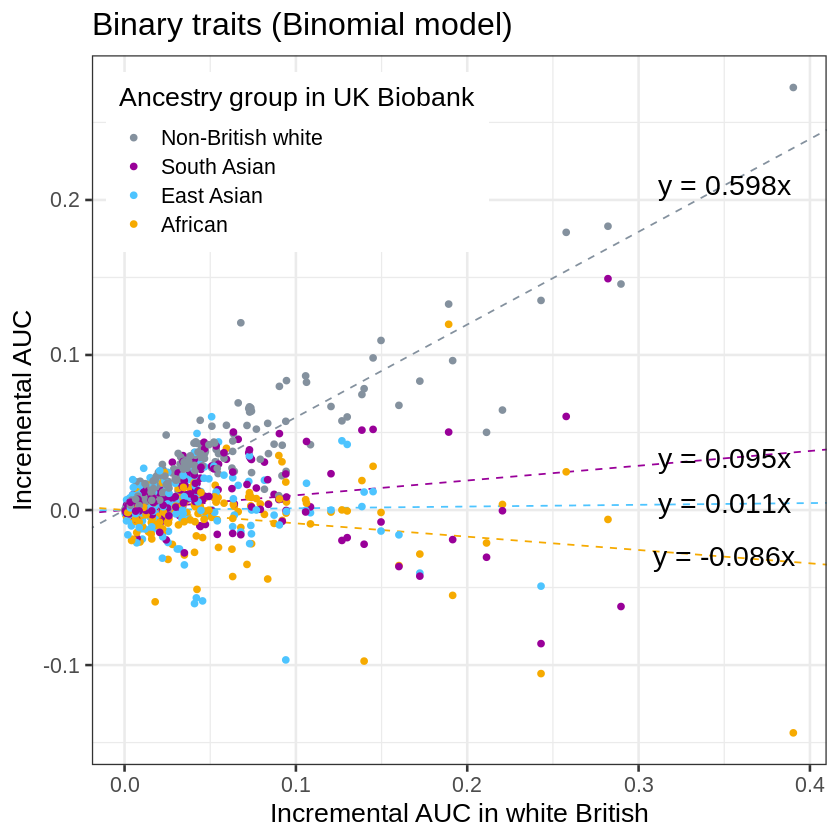

In [159]:
p_trans_scatter_binomial

In [160]:
for(ext in c('png', 'pdf')){ggsave(
    sprintf('transferability.%s', ext),
    gridExtra::arrangeGrob(
        p_trans_violin_binomial,
        p_trans_violin_gaussian,
        p_trans_scatter_binomial,
        p_trans_scatter_gaussian,
        ncol=2
    ),
    width=16, height=16
)}
